# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [44]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
import os
import zipfile
from torch.utils.data import DataLoader

In [11]:
zip = zipfile.ZipFile('processed_celeba_small.zip')
zip.extractall()

In [ ]:
import shutil
shutil.rmtree('/path/to/your/dir/')

In [45]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    images = datasets.ImageFolder(data_dir, transform=transform)
    data_loader = DataLoader(images, batch_size = batch_size, shuffle=True) 
    return data_loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [46]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

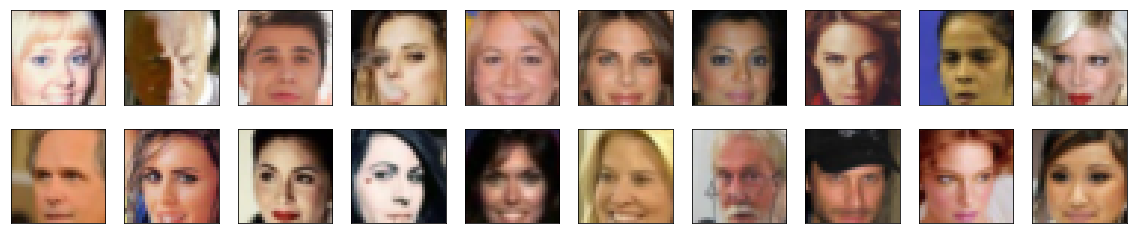

In [47]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [48]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x*(feature_range[1]-feature_range[0])+feature_range[0]
    return x

In [49]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(0.9765)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [50]:
import torch.nn as nn
import torch.nn.functional as F
import problem_unittests as tests

In [51]:
def conv(in_channels,out_channels, kernel_size, stride=2, padding=1,batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels,out_channels, kernel_size, stride, padding, bias= False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers) 

In [52]:
def deconv(in_channels,out_channels, kernel_size, stride=2, padding=1,batch_norm=True):
    layers = []
    transpose_conv = nn.ConvTranspose2d(in_channels,out_channels, kernel_size, stride=2, padding=1, bias = False)
    layers.append(transpose_conv)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))  
    
    return nn.Sequential(*layers)
    

In [53]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        print("Conv Dim", conv_dim)
        self.conv1 = conv(3,conv_dim,4, batch_norm=False)
        self.conv2 = conv(conv_dim,conv_dim*2,4, batch_norm=False)
        self.conv3 = conv(conv_dim*2,conv_dim*4,4, batch_norm=False)
        self.fc = nn.Linear(conv_dim*4*4*4,1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x),0.2)
        out = F.leaky_relu(self.conv2(out),0.2)
        out = F.leaky_relu(self.conv3(out),0.2)
        
        out = out.view(-1,self.conv_dim*4*4*4)
        out = self.fc(out)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Conv Dim 10
Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [54]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        print("z_size is ", z_size)
        self.fc = nn.Linear(z_size,conv_dim*4*4*4)
        self.tconv1 = deconv(conv_dim*4,conv_dim*2,4)
        self.tconv2 = deconv(conv_dim*2,conv_dim,4) 
        self.tconv3 = deconv(conv_dim,3,4,batch_norm=False) 

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1,self.conv_dim*4,4,4)
        out = F.relu(self.tconv1(out))
        out = F.relu(self.tconv2(out))
        out = F.relu(self.tconv3(out))
        out = F.tanh(out)        
        return out

         
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

z_size is  25
Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [55]:
from torch.nn import init
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight, mean = 0, std = 0.02)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)        

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [57]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Conv Dim 64
z_size is  50
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=50, out_features=4096, bias=True)
  (tconv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (tconv3): Sequential(
    (0): ConvTranspose2d(6

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [58]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [59]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(),labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [60]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.SGD(G.parameters(), lr=0.01)

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [61]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda()

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            d_r_output = D(real_images)
            r_image_loss = real_loss(d_r_output)
                
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            d_f_output = D(fake_images)
            f_image_loss = fake_loss(d_f_output)
            d_loss = r_image_loss + f_image_loss
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            generated_images = G(z)
            d_f_output1 = D(generated_images)
            g_loss = real_loss(d_f_output1)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [41]:
d_optimizer.zero_grad()
g_optimizer.zero_grad()   

In [35]:
torch.initial_seed()

5504132384908831298

In [ ]:
# set number of epochs 
n_epochs = 20


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   20] | d_loss: 1.3833 | g_loss: 0.6937
Epoch [    1/   20] | d_loss: 0.7106 | g_loss: 0.6955
Epoch [    1/   20] | d_loss: 0.6783 | g_loss: 0.7081
Epoch [    1/   20] | d_loss: 0.6746 | g_loss: 0.7124
Epoch [    1/   20] | d_loss: 0.6702 | g_loss: 0.7168
Epoch [    1/   20] | d_loss: 0.6655 | g_loss: 0.7219
Epoch [    1/   20] | d_loss: 0.6607 | g_loss: 0.7268
Epoch [    1/   20] | d_loss: 0.6558 | g_loss: 0.7320
Epoch [    1/   20] | d_loss: 0.6510 | g_loss: 0.7372
Epoch [    1/   20] | d_loss: 0.6463 | g_loss: 0.7424
Epoch [    1/   20] | d_loss: 0.6416 | g_loss: 0.7476
Epoch [    1/   20] | d_loss: 0.6369 | g_loss: 0.7529
Epoch [    1/   20] | d_loss: 0.6323 | g_loss: 0.7582
Epoch [    1/   20] | d_loss: 0.6278 | g_loss: 0.7631
Epoch [    1/   20] | d_loss: 0.6232 | g_loss: 0.7684
Epoch [    1/   20] | d_loss: 0.6187 | g_loss: 0.7737
Epoch [    1/   20] | d_loss: 0.6142 | g_loss: 0.7789
Epoch [    1/   20] | d_loss: 0.6098 | g_loss: 0.7842
Epoch [    1/   20] | d_loss

Epoch [    2/   20] | d_loss: 0.2240 | g_loss: 1.6061
Epoch [    2/   20] | d_loss: 0.2223 | g_loss: 1.6130
Epoch [    2/   20] | d_loss: 0.2206 | g_loss: 1.6198
Epoch [    2/   20] | d_loss: 0.2189 | g_loss: 1.6267
Epoch [    2/   20] | d_loss: 0.2172 | g_loss: 1.6336
Epoch [    2/   20] | d_loss: 0.2155 | g_loss: 1.6406
Epoch [    2/   20] | d_loss: 0.2139 | g_loss: 1.6475
Epoch [    2/   20] | d_loss: 0.2122 | g_loss: 1.6544
Epoch [    2/   20] | d_loss: 0.2106 | g_loss: 1.6614
Epoch [    2/   20] | d_loss: 0.2090 | g_loss: 1.6683
Epoch [    2/   20] | d_loss: 0.2074 | g_loss: 1.6753
Epoch [    2/   20] | d_loss: 0.2058 | g_loss: 1.6822
Epoch [    2/   20] | d_loss: 0.2042 | g_loss: 1.6892
Epoch [    2/   20] | d_loss: 0.2026 | g_loss: 1.6962
Epoch [    2/   20] | d_loss: 0.2010 | g_loss: 1.7032
Epoch [    2/   20] | d_loss: 0.1995 | g_loss: 1.7102
Epoch [    2/   20] | d_loss: 0.1980 | g_loss: 1.7172
Epoch [    2/   20] | d_loss: 0.1964 | g_loss: 1.7243
Epoch [    2/   20] | d_loss

Epoch [    4/   20] | d_loss: 0.0674 | g_loss: 2.7314
Epoch [    4/   20] | d_loss: 0.0668 | g_loss: 2.7392
Epoch [    4/   20] | d_loss: 0.0663 | g_loss: 2.7470
Epoch [    4/   20] | d_loss: 0.0658 | g_loss: 2.7548
Epoch [    4/   20] | d_loss: 0.0652 | g_loss: 2.7624
Epoch [    4/   20] | d_loss: 0.0647 | g_loss: 2.7703
Epoch [    4/   20] | d_loss: 0.0642 | g_loss: 2.7781
Epoch [    4/   20] | d_loss: 0.0637 | g_loss: 2.7860
Epoch [    4/   20] | d_loss: 0.0632 | g_loss: 2.7938
Epoch [    4/   20] | d_loss: 0.0626 | g_loss: 2.8013
Epoch [    4/   20] | d_loss: 0.0621 | g_loss: 2.8094
Epoch [    4/   20] | d_loss: 0.0618 | g_loss: 2.8168
Epoch [    4/   20] | d_loss: 0.0610 | g_loss: 2.8279
Epoch [    4/   20] | d_loss: 0.0605 | g_loss: 2.8346
Epoch [    4/   20] | d_loss: 0.0601 | g_loss: 2.8413
Epoch [    4/   20] | d_loss: 0.0597 | g_loss: 2.8481
Epoch [    4/   20] | d_loss: 0.0593 | g_loss: 2.8547
Epoch [    4/   20] | d_loss: 0.0591 | g_loss: 2.8624
Epoch [    4/   20] | d_loss

Epoch [    6/   20] | d_loss: 0.0202 | g_loss: 3.9100
Epoch [    6/   20] | d_loss: 0.0201 | g_loss: 3.9181
Epoch [    6/   20] | d_loss: 0.0199 | g_loss: 3.9261
Epoch [    6/   20] | d_loss: 0.0198 | g_loss: 3.9342
Epoch [    6/   20] | d_loss: 0.0196 | g_loss: 3.9423
Epoch [    6/   20] | d_loss: 0.0194 | g_loss: 3.9504
Epoch [    6/   20] | d_loss: 0.0193 | g_loss: 3.9585
Epoch [    6/   20] | d_loss: 0.0191 | g_loss: 3.9665
Epoch [    6/   20] | d_loss: 0.0190 | g_loss: 3.9746
Epoch [    6/   20] | d_loss: 0.0188 | g_loss: 3.9827
Epoch [    6/   20] | d_loss: 0.0187 | g_loss: 3.9908
Epoch [    6/   20] | d_loss: 0.0185 | g_loss: 3.9989
Epoch [    6/   20] | d_loss: 0.0184 | g_loss: 4.0070
Epoch [    6/   20] | d_loss: 0.0182 | g_loss: 4.0150
Epoch [    6/   20] | d_loss: 0.0181 | g_loss: 4.0231
Epoch [    6/   20] | d_loss: 0.0179 | g_loss: 4.0312
Epoch [    6/   20] | d_loss: 0.0178 | g_loss: 4.0393
Epoch [    6/   20] | d_loss: 0.0176 | g_loss: 4.0474
Epoch [    6/   20] | d_loss

Epoch [    7/   20] | d_loss: 0.0068 | g_loss: 4.9933
Epoch [    7/   20] | d_loss: 0.0068 | g_loss: 5.0011
Epoch [    7/   20] | d_loss: 0.0067 | g_loss: 5.0092
Epoch [    7/   20] | d_loss: 0.0066 | g_loss: 5.0173
Epoch [    7/   20] | d_loss: 0.0066 | g_loss: 5.0253
Epoch [    7/   20] | d_loss: 0.0065 | g_loss: 5.0334
Epoch [    7/   20] | d_loss: 0.0065 | g_loss: 5.0415
Epoch [    7/   20] | d_loss: 0.0064 | g_loss: 5.0496
Epoch [    7/   20] | d_loss: 0.0064 | g_loss: 5.0578
Epoch [    7/   20] | d_loss: 0.0063 | g_loss: 5.0658
Epoch [    7/   20] | d_loss: 0.0063 | g_loss: 5.0739
Epoch [    7/   20] | d_loss: 0.0062 | g_loss: 5.0821
Epoch [    7/   20] | d_loss: 0.0062 | g_loss: 5.0901
Epoch [    7/   20] | d_loss: 0.0061 | g_loss: 5.0983
Epoch [    7/   20] | d_loss: 0.0061 | g_loss: 5.1064
Epoch [    7/   20] | d_loss: 0.0060 | g_loss: 5.1145
Epoch [    7/   20] | d_loss: 0.0060 | g_loss: 5.1226
Epoch [    7/   20] | d_loss: 0.0059 | g_loss: 5.1307
Epoch [    7/   20] | d_loss

Epoch [    9/   20] | d_loss: 0.0020 | g_loss: 6.2325
Epoch [    9/   20] | d_loss: 0.0020 | g_loss: 6.2407
Epoch [    9/   20] | d_loss: 0.0019 | g_loss: 6.2489
Epoch [    9/   20] | d_loss: 0.0019 | g_loss: 6.2566
Epoch [    9/   20] | d_loss: 0.0019 | g_loss: 6.2650
Epoch [    9/   20] | d_loss: 0.0019 | g_loss: 6.2734
Epoch [    9/   20] | d_loss: 0.0018 | g_loss: 6.4319
Epoch [    9/   20] | d_loss: 0.0019 | g_loss: 6.2898
Epoch [    9/   20] | d_loss: 0.0018 | g_loss: 6.2980
Epoch [    9/   20] | d_loss: 0.0018 | g_loss: 6.3062
Epoch [    9/   20] | d_loss: 0.0018 | g_loss: 6.3144
Epoch [    9/   20] | d_loss: 0.0018 | g_loss: 6.3226
Epoch [    9/   20] | d_loss: 0.0018 | g_loss: 6.3308
Epoch [    9/   20] | d_loss: 0.0018 | g_loss: 6.3390
Epoch [    9/   20] | d_loss: 0.0018 | g_loss: 6.3471
Epoch [    9/   20] | d_loss: 0.0017 | g_loss: 6.3553
Epoch [    9/   20] | d_loss: 0.0017 | g_loss: 6.3635
Epoch [    9/   20] | d_loss: 0.0017 | g_loss: 6.3717
Epoch [    9/   20] | d_loss

Epoch [   11/   20] | d_loss: 0.0006 | g_loss: 7.4768
Epoch [   11/   20] | d_loss: 0.0006 | g_loss: 7.4850
Epoch [   11/   20] | d_loss: 0.0006 | g_loss: 7.4932
Epoch [   11/   20] | d_loss: 0.0006 | g_loss: 7.5014
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5096
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5178
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5260
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5342
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5424
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5506
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5588
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5670
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5752
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5834
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5916
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.5998
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.6080
Epoch [   11/   20] | d_loss: 0.0005 | g_loss: 7.6162
Epoch [   11/   20] | d_loss

Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.7225
Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.7307
Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.7390
Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.7471
Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.7554
Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.7636
Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.7718
Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.7800
Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.7882
Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.7964
Epoch [   12/   20] | d_loss: 0.0002 | g_loss: 8.8046
Epoch [   12/   20] | d_loss: 0.0001 | g_loss: 8.8128
Epoch [   12/   20] | d_loss: 0.0001 | g_loss: 8.8210
Epoch [   12/   20] | d_loss: 0.0001 | g_loss: 8.8292
Epoch [   12/   20] | d_loss: 0.0001 | g_loss: 8.8374
Epoch [   12/   20] | d_loss: 0.0001 | g_loss: 8.8456
Epoch [   13/   20] | d_loss: 0.0001 | g_loss: 8.8533
Epoch [   13/   20] | d_loss: 0.0001 | g_loss: 8.8615
Epoch [   13/   20] | d_loss

Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 9.9681
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 9.9763
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 9.9845
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 9.9927
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0009
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0091
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0173
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0255
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0337
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0419
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0501
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0583
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0665
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0747
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0829
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0911
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.0993
Epoch [   14/   20] | d_loss: 0.0000 | g_loss: 10.1075
Epoch [   14/ 

Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.1973
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2055
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2137
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2219
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2301
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2383
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2465
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2547
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2629
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2711
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2793
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2875
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.2957
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.3039
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.3121
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.3203
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.3285
Epoch [   16/   20] | d_loss: 0.0000 | g_loss: 11.3367
Epoch [   

Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4174
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4256
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4338
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4420
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4502
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4583
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4665
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4747
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4829
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4911
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.4993
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.5075
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.5156
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.5238
Epoch [   17/   20] | d_loss: 0.0000 | g_loss: 12.5320
Epoch [   18/   20] | d_loss: 0.0000 | g_loss: 12.5397
Epoch [   18/   20] | d_loss: 0.0000 | g_loss: 12.5479
Epoch [   18/   20] | d_loss: 0.0000 | g_loss: 12.5561
Epoch [   

Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.6340
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.6422
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.6504
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.6587
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.6670
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.6752
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.6831
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.6911
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.6992
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.7074
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.7156
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.7238
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.7322
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.7404
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.7484
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.7563
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.7644
Epoch [   19/   20] | d_loss: 0.0000 | g_loss: 13.7725
Epoch [   

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [1]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

NameError: name 'plt' is not defined

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [36]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [37]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

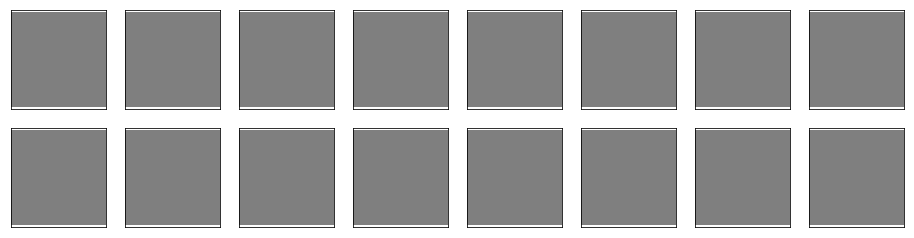

In [38]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.